The dataset comes from [this website](https://www.cityscapes-dataset.com/dataset-overview/) and you can download it at [this direct link](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip).

A faire :
- [x] Comprendre ce qu'est et pourquoi utiliser un "générateur à la volée". Script [ici](https://github.com/srihari-humbarwadi/cityscapes-segmentation-with-Unet/blob/master/batch_training.py).
  - Finalement le script a l'air d'avoir été fait avec un ancien générateur python. Au pire on aurait utilisé le mot clef yield mais mieux encore, il y a le tf.data.Dataset qui va nous aider à le faire.
- [x] Définir quelles sont les variables dont on aura besoin pour entrainer notre modèle
- [ ] Créer un générateur pour récupérer ces données.
- [x] Entrainer le modèle

Ressources :
1. Un guide classique sur la segmentation image avec exactement ce dataset [ici](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html)
2. A entrainé Unet sur le dataset [ici](https://github.com/srihari-humbarwadi/cityscapes-segmentation-with-Unet)
3. Kaggle d'entrainement de PSPNet sur le dataset [ici](https://www.kaggle.com/code/santhalnr/cityscapes-image-segmentation-pspnet/notebook)
4. La doc de python [ici](https://docs.python.org/3/index.html)
   

# Gathering the data

## Downloading

In [1]:
import zipfile
import urllib

from url import file1_url, file2_url

# Will try to download the files

# Dataset archive whith labels
file_path = 'P8_Cityscapes_gtFine_trainvaltest.zip'
# Dataset archive with images
file_path_2 = 'P8_Cityscapes_leftImg8bit_trainvaltest.zip'

# Check if file exists
if not os.path.isfile(file_path):
    print(f'{file_path} archive does not exist. Downloading from internet...')
    urllib.request.urlretrieve(file1_url, file_path)
    print('Download complete.')

# Check if file exists
if not os.path.isfile(file_path_2):
    print(f'{file_path_2} archive does not exist. Downloading from internet...')
    urllib.request.urlretrieve(file2_url, file_path_2)
    print('Download complete.')


## Extraction

In [2]:
# Create another directory and extract the file in it
path_to_extract = f'dataset/'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract)

# Create another directory and extract the file in it
with zipfile.ZipFile(file_path_2, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract)

# Sorting images and preprocessing

We know that we need to sort images into folder for training, testing and validation.

## Sorting images into folders

In [1]:
import shutil
import os
import random
from tqdm.autonotebook import tqdm
import numpy as np
from labels import *
import cv2
import matplotlib.pyplot as plt

training_folder = r"dataset\leftImg8bit\train"

# List of all subfolders
subfolders = os.listdir(training_folder)

# List of all images paths in the subfolders
images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(training_folder, subfolder)):
        images.append(os.path.join(training_folder, subfolder, image))


# Same for labelling
labelling_folder = r"dataset\gtFine\train"

# List of all subfolders
subfolders = os.listdir(labelling_folder)

# List of all images paths in the subfolders
labels_images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(labelling_folder, subfolder)):
        if image.endswith('labelIds.png'):
            labels_images.append(os.path.join(labelling_folder, subfolder, image))

tuple_images_labels = list(zip(images, labels_images))


# Same for validation
validation_folder = r"dataset\leftImg8bit\val"

# List of all subfolders
subfolders = os.listdir(validation_folder)

# List of all images paths in the subfolders
val_images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(validation_folder, subfolder)):
        val_images.append(os.path.join(validation_folder, subfolder, image))


# Same for labelling
validation_labelling_folder = r"dataset\gtFine\train"

# List of all subfolders
subfolders = os.listdir(validation_labelling_folder)

# List of all images paths in the subfolders
val_labels_images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(validation_labelling_folder, subfolder)):
        if image.endswith('labelIds.png'):
            val_labels_images.append(os.path.join(validation_labelling_folder, subfolder, image))

tuple_val_images_labels = list(zip(val_images, val_labels_images))

In [4]:
# Creating folder training_data
training_data_folder = r"processed_data\training_data"
if os.path.exists(training_data_folder):
    shutil.rmtree(training_data_folder)
os.makedirs(training_data_folder)

# Creating training_labels folder
training_labels_folder = r"processed_data\training_labels"
if os.path.exists(training_labels_folder):
    shutil.rmtree(training_labels_folder)
os.makedirs(training_labels_folder)

for image, label in random.choices(tuple_images_labels, k=500):
    # get image name
    image_name = os.path.basename(image)[:-16] + '.png'
    # Copy image to training_data folder and rename it
    shutil.copy(image, os.path.join(training_data_folder, image_name))
    # Copy label to training_labels folder
    shutil.copy(label, os.path.join(training_labels_folder, image_name))




# Creating validation_data folder
validation_data_folder = r"processed_data\validation_data"
if not os.path.exists(validation_data_folder):
    os.makedirs(validation_data_folder)

# Creating validation_labels folder
validation_labels_folder = r"processed_data\validation_labels"
if not os.path.exists(validation_labels_folder):
    os.makedirs(validation_labels_folder)

for image, label in random.choices(tuple_val_images_labels, k=10):
    # get image name
    image_name = os.path.basename(image)[:-16] + '.png'
    # Copy image to validation_data_folder folder and rename it
    shutil.copy(image, os.path.join(validation_data_folder, image_name))
    # Copy label to validation_labels_folder folder
    shutil.copy(label, os.path.join(validation_labels_folder, image_name))

## Resizing images

Many models require images to be of a certain size. We make a function to make it easier when we'll choose our model.

In [5]:
def resize_images(folder, new_size):
    print(f"Resizing training images in {folder} to {new_size} ...")
    for image in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, image))
        img = cv2.resize(img, new_size)
        cv2.imwrite(os.path.join(folder, image), img)
    print("Done")

C:\Users\barau\AppData\Local\Temp\ipykernel_17736\3980961677.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Converting the labels to their categories id

Let's convert id of the label to the category id because we only need to predict those 8 categories and not the 30+ labels. You'll find the difference [here](https://www.cityscapes-dataset.com/dataset-overview/#class-definitions).

In [6]:
# Create dictionnary for {labelId : label}
id2categoryId = { int(label.id) : int(label.categoryId) for label in labels}

# Create a lambda function that returns the categoryId of a labelId
getCatId = lambda labelId: id2categoryId[labelId]

# Create a vectorized function
matrixId2categoryId = np.vectorize(getCatId)

def convert_labels(folder):
    print(f"Converting labels in {folder} ...")
    for image in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, image))
        img = matrixId2categoryId(img)
        cv2.imwrite(os.path.join(folder, image), img)
    print("Done")

Different values with the labels id : [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]


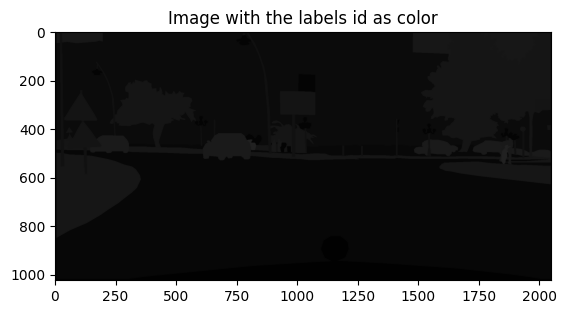

Different values with the categories id : [0 1 2 3 4 5 6 7]


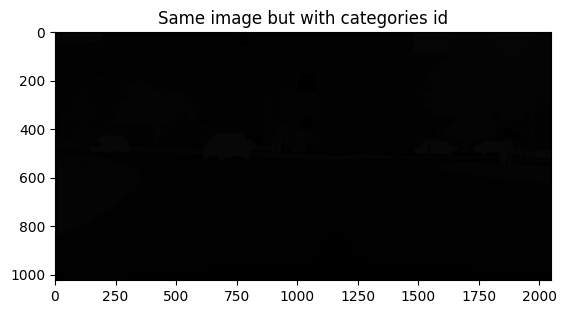

In [7]:
image = cv2.imread(r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\gtFine\train\aachen\aachen_000000_000019_gtFine_labelIds.png", cv2.IMREAD_COLOR)
print(f"Different values with the labels id : {np.unique(image)}")
plt.imshow(image)
plt.title("Image with the labels id as color")
plt.show()


image = matrixId2categoryId(image)

print(f"Different values with the categories id : {np.unique(image)}")
image = image.astype(np.uint8)
plt.imshow(image)
plt.title("Same image but with categories id")
plt.show()

# Getting familiar with the keras_segmentation library

## Testing a model with a pre-trained model

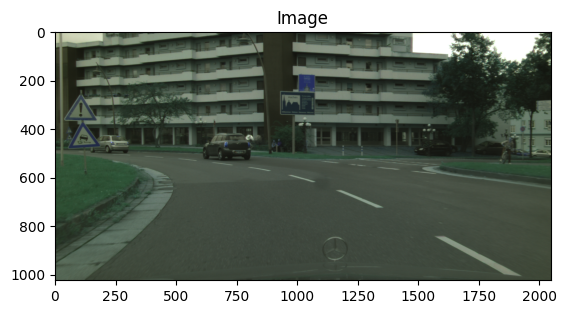

1/1 [==============================] - 2s 2s/step


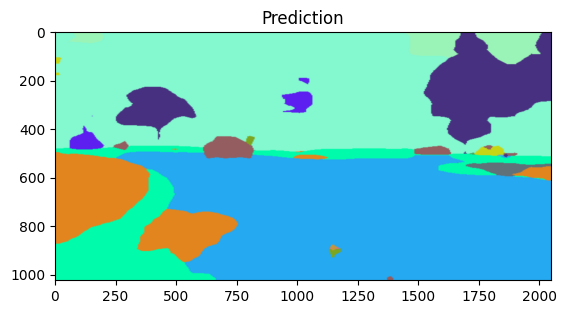

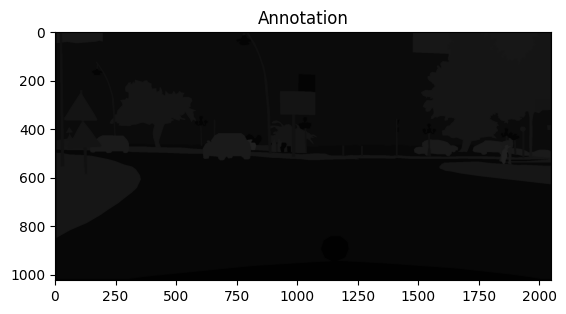

In [8]:
# Test of the module with pre-trained model
from keras_segmentation.pretrained import pspnet_50_ADE_20K


model = pspnet_50_ADE_20K()

test_image = r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\leftImg8bit\train\aachen\aachen_000000_000019_leftImg8bit.png"

test_image_label = r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\gtFine\train\aachen\aachen_000000_000019_gtFine_labelIds.png"

base_image = cv2.imread(test_image, cv2.IMREAD_COLOR)
plt.imshow(base_image)
plt.title("Image")
plt.show()

model.predict_segmentation(
    inp=test_image,
    out_fname="out.png"
)

img = cv2.imread("out.png")
plt.title("Prediction")
plt.imshow(img)
plt.show()

img_annotation = cv2.imread(test_image_label)
plt.title("Annotation")
plt.imshow(img_annotation)
plt.show()


In [9]:
# It is not possible to evaluate this model because it was trained on other classes/labels than the ones we want to predict
# But for future models :

def show_metrics(evaluation):
    print(f"Mean IU : {round(evaluation['mean_IU'],3)}")
    categories_set = {label.categoryId : label.name for label in labels}
    for i, cat in enumerate(categories_set):
        print(f"-- {categories_set[cat]} : {round(evaluation['class_wise_IU'][i],3)} IU")


def evaluate_seg_model(model, validation_data_folder, validation_labels_folder):
    evaluation = model.evaluate_segmentation(inp_images_dir=validation_data_folder  , annotations_dir=validation_labels_folder)
    show_metrics(evaluation)

# Training model from scratch

A segmentation model is composed by an encoder and a decoder.

The model we will use here is called fcn_32 (`fcn` because of its architecture, FullyConvolutionnalNetwork) and 32 because the result has been upsampled 32 times. It is a lot compared to fcn_8 so it will have worse results but it will be faster to train.

From [this article](https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1).

![upsamplingExplainingFCNDifference](https://miro.medium.com/max/875/1*lUnNaKAjL-Mq10v3tIBtJg.png)

After selecting our architecture, we'll have to choose our decoder. Here we chose "vanilla_encoder" from [here](https://github.com/divamgupta/image-segmentation-keras/blob/master/keras_segmentation/models/basic_models.py). This encoder isn't already trained on ImageNet (unlike Unet, MobileNet or ResNet) so the reasults will be poor. But I think it is a good start.

In [10]:
# First, we need to convert labels to categorical

convert_labels(training_labels_folder)
convert_labels(validation_labels_folder)

Converting labels in processed_data\training_labels ...


100%|██████████| 846/846 [07:39<00:00,  1.84it/s]


Done
Converting labels in processed_data\validation_labels ...


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

Done


In [13]:
import pickle

from keras_segmentation.models.fcn import fcn_32

model = fcn_32(n_classes=8 ,  input_height=416, input_width=608)

# Creating checkpoint folder
checkpoint_folder = f"tmp\{model.model_name}"
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

# If there is a checkpoint, load it
if os.path.exists(os.path.join(checkpoint_folder, "checkpoint")):
    model.load_weights(os.path.join(checkpoint_folder, "model.h5"))
    print("Model loaded.")


model.train(
    train_images =  training_data_folder,
    train_annotations = training_labels_folder,
    checkpoints_path = checkpoint_folder + f"\{model.model_name}.ckpt",
    epochs=1,
    steps_per_epoch=64,
    verify_dataset = False,
    )

model.save(os.path.join(checkpoint_folder, "model.h5"))

64/64 [==============================] - 245s 4s/step - loss: 2.0795 - accuracy: 0.1248


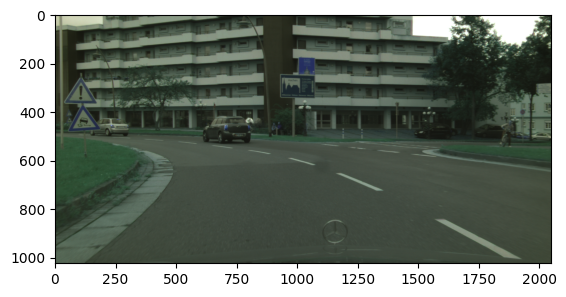

1/1 [==============================] - 1s 562ms/step


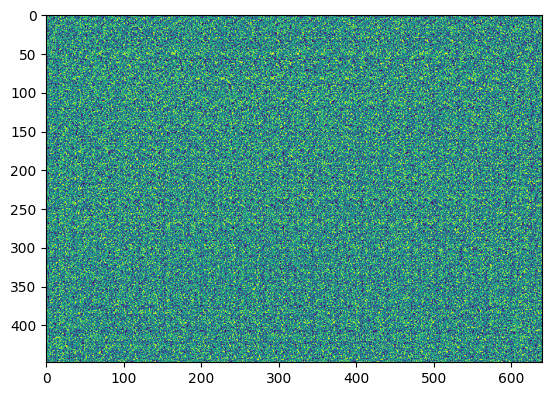

In [14]:
plt.imshow(cv2.imread(test_image, cv2.IMREAD_COLOR))
plt.show()

out = model.predict_segmentation(
    inp=test_image,
    out_fname="out.png"
)

plt.imshow(out)
plt.show()

In [15]:
evaluate_seg_model(model, validation_data_folder, validation_labels_folder)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 451ms/step


1it [00:00,  1.46it/s]

1/1 [==============================] - 0s 442ms/step


2it [00:01,  1.43it/s]

1/1 [==============================] - 0s 421ms/step


3it [00:02,  1.47it/s]

1/1 [==============================] - 0s 421ms/step


4it [00:02,  1.51it/s]

1/1 [==============================] - 0s 421ms/step


5it [00:03,  1.53it/s]

1/1 [==============================] - 0s 482ms/step


6it [00:04,  1.48it/s]

1/1 [==============================] - 0s 476ms/step


7it [00:04,  1.44it/s]

1/1 [==============================] - 1s 520ms/step


8it [00:05,  1.41it/s]

1/1 [==============================] - 0s 382ms/step


9it [00:06,  1.47it/s]

Mean IU : 0.051
-- ground : 0.052 IU
-- rail track : 0.101 IU
-- tunnel : 0.101 IU
-- traffic sign : 0.02 IU
-- terrain : 0.057 IU
-- sky : 0.022 IU
-- rider : 0.013 IU
-- license plate : 0.039 IU


## Training model from a trained encoder (mobileNet)

Now that we found that our previous results weren't very good, we'll try another approach with a different architecture and a different encoder.

The encoder used will be VGG16 with a PSPNet architecture (from [here](https://github.com/divamgupta/image-segmentation-keras/blob/b9171a326502587fdd089754234967416631f482/keras_segmentation/models/pspnet.py#L85)).

In [ ]:
import pickle

from keras_segmentation.models.pspnet import vgg_pspnet

model = vgg_pspnet(n_classes=8 ,  input_height=416, input_width=608)

# Creating checkpoint folder
checkpoint_folder = f"tmp\{model.model_name}"
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

# If there is a checkpoint, load it
if os.path.exists(os.path.join(checkpoint_folder, "checkpoint")):
    model.load_weights(os.path.join(checkpoint_folder, "model.h5"))
    print("Model loaded.")


model.train(
    train_images =  training_data_folder,
    train_annotations = training_labels_folder,
    checkpoints_path = checkpoint_folder + f"\{model.model_name}.ckpt", epochs=10)

model.save(os.path.join(checkpoint_folder, "model.h5"))

In [ ]:
plt.imshow(cv2.imread(val_test_image, cv2.IMREAD_COLOR))
plt.show()

out = model.predict_segmentation(
    inp=val_test_image,
    out_fname="out.png"
)

plt.imshow(out)
plt.show()

In [ ]:
evaluate_seg_model(model, validation_data_folder, validation_labels_folder)